In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [2]:
pickle_file = '../data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [3]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
    "DIALYSIS_TIME",
    "KDPI",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# X = pipeline.fit_transform(dataset[categorical_features + numeric_features ])

categorical_x = encode_categorical(dataset[categorical_features])
numerical_x = standardize(dataset[numeric_features])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [ ]:
rsf = RandomSurvivalForest(n_estimators=3, n_jobs=-1, random_state=42, low_memory=True)
rsf.fit(X_train[1000:], y_train[1000:])

In [ ]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

# evaluate_model(rsf, X_test, y_test, y_train, times)
evaluate_model_uno_c(rsf, X_test[500:], y_test[500:], y_train[1000:], times)

(0.6561443562837068, 93442780, 48802771, 7527, 21256)

In [ ]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [ ]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_train.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

                   Importance
AGE                  0.074386
DIAB=5.0             0.017916
DIAB=3.0             0.017344
AGE_DON              0.007767
DIALYSIS_TIME        0.006307
ON_DIALYSIS=Y        0.005970
CREAT_TRR            0.005387
KDPI                 0.005051
DIAB=2.0             0.003718
ETHCAT=4             0.003144
BMI_CALC             0.002441
GENDER=M             0.002063
HCV_SEROSTATUS=P     0.002005
COLD_ISCH_KI         0.001304
ETHCAT=5             0.001257
PRE_TX_TXFUS=Y       0.000940
ETHCAT=2             0.000689
NPKID                0.000417
ETHCAT=7             0.000029
DIAB=4.0             0.000024
HCV_SEROSTATUS=ND   -0.000039
ETHCAT=6            -0.000046
DIAB=998.0          -0.000049
DIABETES_DON=Y      -0.000500


In [ ]:
import matplotlib.pyplot as plt
# plt_importances =importances_df.sort_values(by='Importance', ascending=True)
# plt_importances.plot.barh(color='blue', legend=False, title='RSF Feature Permutation Importance Deceased', grid=True, figsize=(8, 9))
# path = "../../Thesis/Images/Results/"
# plt.savefig(path + "RSF_FI_deceased.pdf", bbox_inches="tight")

### Performed on helios
| Feature | Importance |
|---:|---:|
| AGE                | 7.603468e-02 |
| DIAB=5.0           | 1.755682e-02 |
| DIAB=3.0           | 1.636021e-02 |
| CREAT_TRR          | 6.719912e-03 |
| ON_DIALYSIS=Y      | 6.290068e-03 |
| AGE_DON            | 4.584326e-03 |
| KDPI               | 4.224856e-03 |
| DIALYSIS_TIME      | 3.907660e-03 |
| KDRI_RAO           | 3.656396e-03 |
| HCV_SEROSTATUS=P   | 3.371945e-03 |
| DIAB=2.0           | 3.240055e-03 |
| ETHCAT=4           | 2.897624e-03 |
| BMI_CALC           | 2.440851e-03 |
| ETHCAT=5           | 2.209945e-03 |
| PRE_TX_TXFUS=Y     | 1.797013e-03 |
| ETHCAT=2           | 1.152406e-03 |
| COLD_ISCH_KI       | 1.093853e-03 |
| NPKID              | 4.144752e-04 |
| HCV_SEROSTATUS=ND  | 2.775765e-04 |
| GENDER=M           | 1.363486e-04 |
| ETHCAT=6           | 6.727253e-05 |
| CREAT_DON          | 1.390463e-05 |
| ETHCAT=7           | 1.339929e-07 |
| DIAB=4.0           |-3.417864e-05 |
| DIAB=998.0         |-3.806376e-05 |
| DIABETES_DON=Y     |-1.558873e-04 |


In [ ]:
import pandas as pd

data = {
    'Importance': [
        7.603468e-02, 1.755682e-02, 1.636021e-02, 6.719912e-03, 6.290068e-03,
        4.584326e-03, 4.224856e-03, 3.907660e-03, 3.656396e-03, 3.371945e-03,
        3.240055e-03, 2.897624e-03, 2.440851e-03, 2.209945e-03, 1.797013e-03,
        1.152406e-03, 1.093853e-03, 4.144752e-04, 2.775765e-04, 1.363486e-04,
        6.727253e-05, 1.390463e-05, 1.339929e-07, -3.417864e-05, -3.806376e-05,
        -1.558873e-04
    ]
}

index = [
    'AGE', 'DIAB=5.0', 'DIAB=3.0', 'CREAT_TRR', 'ON_DIALYSIS=Y',
    'AGE_DON', 'KDPI', 'DIALYSIS_TIME', 'KDRI_RAO', 'HCV_SEROSTATUS=P',
    'DIAB=2.0', 'ETHCAT=4', 'BMI_CALC', 'ETHCAT=5', 'PRE_TX_TXFUS=Y',
    'ETHCAT=2', 'COLD_ISCH_KI', 'NPKID', 'HCV_SEROSTATUS=ND', 'GENDER=M',
    'ETHCAT=6', 'CREAT_DON', 'ETHCAT=7', 'DIAB=4.0', 'DIAB=998.0',
    'DIABETES_DON=Y'
]

importances_df1 = pd.DataFrame(data, index=index)

diab = ["DIAB=3.0", "DIAB=5.0", "DIAB=2.0", "DIAB=4.0", "DIAB=998.0"]
eth = ["ETHCAT=2", "ETHCAT=5", "ETHCAT=4", "ETHCAT=6", "ETHCAT=7"] # "ETHCAT=9",
hcv = ["HCV_SEROSTATUS=ND", "HCV_SEROSTATUS=P"]

plt_importances1 =importances_df1.sort_values(by='Importance', ascending=True)
plt_importances1.loc["DIAB", 'Importance'] = plt_importances1.loc[diab, 'Importance'].sum()
plt_importances1.loc["ETHCAT", 'Importance'] = plt_importances1.loc[eth, 'Importance'].sum()
plt_importances1.loc["HCV_SEROSTATUS", 'Importance'] = plt_importances1.loc[hcv, 'Importance'].sum()

plt_importances1.drop(diab, inplace=True)
plt_importances1.drop(eth, inplace=True)
plt_importances1.drop(hcv, inplace=True)

plt_importances1.sort_values(by='Importance', ascending=True, inplace=True)

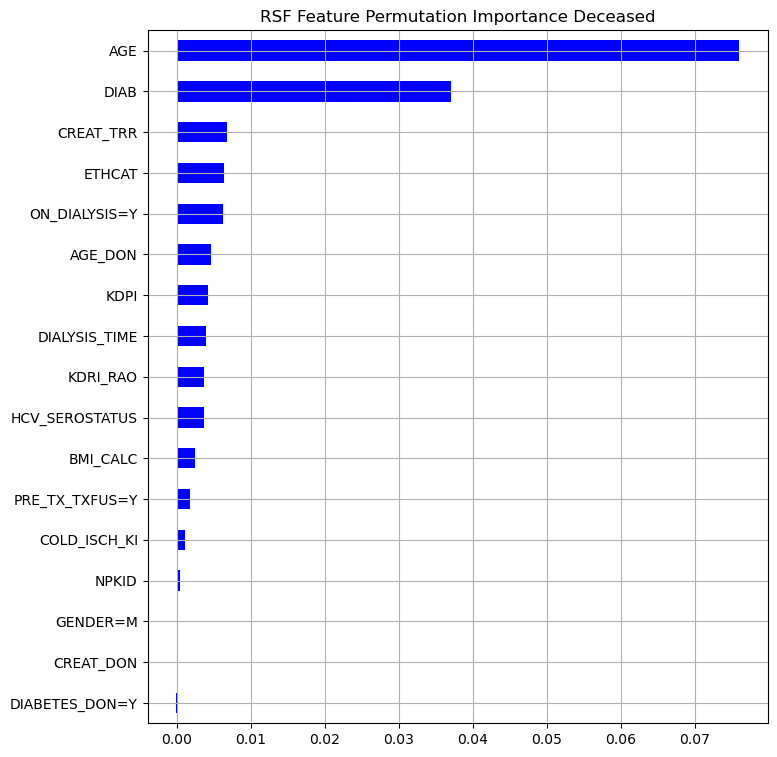

In [12]:
import matplotlib.pyplot as plt
plt_importances1.plot.barh(color='blue', legend=False, title='RSF Feature Permutation Importance Deceased', grid=True, figsize=(8, 9))
path = "../../Thesis/Images/Results/"
plt.savefig(path + "RSF_FI_deceased.pdf", bbox_inches="tight")